# Solving Maxcut with QAOA

**Download this notebook - {nb-download}`pytket_qaoa_maxcut_example.ipynb`**
## The Max-Cut problem

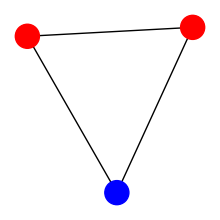

In [1]:

import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
G.add_edges_from([(0, 1), (1, 2), (2, 0)])
plt.figure(figsize=(2, 2))
nx.draw(G, node_color=["red", "blue", "red"])
plt.show()


There are $2^3$ possible assignments of colour to nodes. In general there are $2^n$. The Max-cut problem can then be stated as that of finding the colour assignment which maximises the number of edges between vertices of a different colour.
## Quantum Approximate Optimization Algorithm (QAOA)

Introduced in 'A Quantum Approximate Optimization Algorithm' (found at https://arxiv.org/abs/1411.4028). The idea is to prepare a quantum state which encodes a solution to the Max-cut problem.


This is a variational algorithm, which is to say that a paramaterised state is prepared, with the parameters varied to improve the solution. We will have $2p$ parameters where p is our number of layers. In particular, the state prepared has the form 


$$
| \psi  ( \beta, \gamma ) \rangle = U ( \beta_m ) U ( \gamma_m ) ... U (\beta_0) U ( \gamma_0 ) | \psi_0 \rangle
$$

where

$$
U( \beta_i ) = e^{i \beta_i H_B} \quad \& \quad U ( \gamma_i) = e^{i \gamma_i H_P}
$$

with $H_P$ depending on the problem instance. 
For the previous 3 vertex graph the *problem Hamiltonian* is

$$
H_P = \frac{3}{2} I - \frac{1}{2} \Big[ ( Z \otimes Z \otimes I ) + ( Z \otimes I \otimes Z ) + ( I \otimes Z \otimes Z ) \Big]
$$

where you will notice that there is a $ Z \otimes Z$ acting between each vertex which is connected by an edge.
The *mixer Hamiltonian* has the form 

$$
H_B =   ( X \otimes I \otimes I ) + ( I \otimes X \otimes I ) + ( I \otimes I \otimes X )
$$

where you will notice that there is an $X$ operator acting on each vertex.
## The cost function for Maxcut

A solution to maxcut can be found by maximising the following cost function $C$ .



$$
\begin{equation}
C= \frac{1}{2}\sum_{(i,j)} (1-z_i\,z_j)
\end{equation}
$$

Here $z_i$ and $z_j$ are the the "colours" of each vertex.  

$$
\begin{equation}
z_i,z_j \in \{0,1\}
\end{equation}
$$
The Pauli Z operator can be used to distinguish between the $|0\rangle$ and $|1\rangle$ basis states as these are eigenstates with eigenvalues $\pm 1$ .

$$
\begin{equation}
H_P = \frac{1}{2}\sum_{(i, \,j)} (I-Z_i \,Z_j)
\end{equation}
$$


$$
\begin{equation}
H_B = \sum_i X_i
\end{equation}
$$

Here we use the the convention that $X_i$ means a Pauli X operator will be applied to the "ith" qubit and the identity operator will be applied to all other qubits in the circuit.


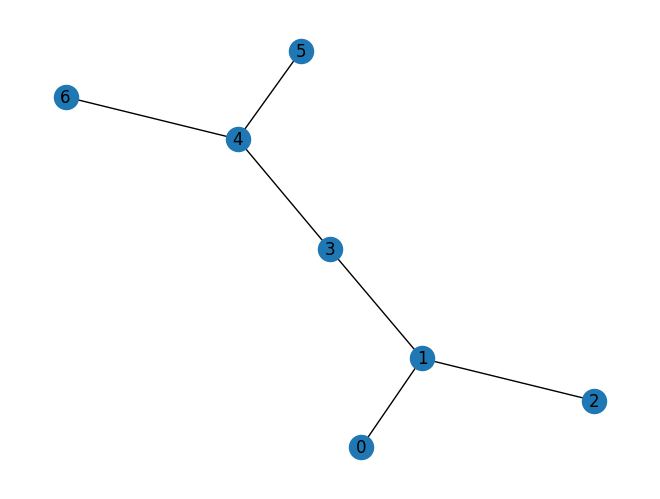

In [2]:

import networkx as nx

max_cut_graph_edges = [(0, 1), (1, 2), (1, 3), (3, 4), (4, 5), (4, 6)]
n_nodes = 7

max_cut_graph = nx.Graph()
max_cut_graph.add_edges_from(max_cut_graph_edges)
nx.draw(max_cut_graph, labels={node: node for node in max_cut_graph.nodes()})

expected_results = [(0, 1, 0, 0, 1, 0, 0), (1, 0, 1, 1, 0, 1, 1)]



## Define Cost Hamiltonian: $\gamma H$
$$
\begin{equation}
H_P = \frac{1}{2}\sum_{(i, \, j)} (I -Z_i \,Z_j)
\end{equation}
$$
$$
\begin{equation}
H_P = 3 I^{\otimes 7} -0.5 \big[ Z_0 Z_1 + Z_1 Z_2 +Z_1 Z_3 +Z_3 Z_4 +Z_4 Z_5 +Z_4 Z_6  \big]
\end{equation}
$$


In [3]:

## Hamiltonian Circuit
## Construction of the Mixer Hamiltonian: $\beta B$
## Define the Initial State
from guppylang import guppy
from guppylang.std.quantum import qubit, h, rx
from guppylang.std.qsystem import zz_phase
from guppylang.std.builtins import array, comptime, frozenarray
from guppylang.std.angles import angle
from guppylang.defs import GuppyFunctionDefinition
import networkx as nx

n_qb = guppy.nat_var("n")


def build_qaoa_instance(graph: nx.Graph, n_layers: int) -> GuppyFunctionDefinition:
    edges = list(graph.edges)
    n_qubits = graph.number_of_nodes()

    @guppy
    def qaoa_instance(
        cost_angles: frozenarray[float, comptime(n_layers)],
        mixer_angles: frozenarray[float, comptime(n_layers)],
    ) -> array[qubit, comptime(n_qubits)]:
        qs = array(qubit() for _ in range(comptime(n_qubits)))
        n = len(qs)
        num_iterations = len(cost_angles)

        for i in range(n):
            h(qs[i])

        for iter_index in range(num_iterations):
            # Add cost layer
            for i, j in comptime(edges):
                zz_phase(qs[i], qs[j], angle(-cost_angles[iter_index] / 2))

            # Add mixer layer
            for i in range(n):
                rx(qs[i], angle(mixer_angles[iter_index]))

        return qs

    return qaoa_instance


We also need to extract our energy expectation values from a `BackendResult` object after our circuit is processed by the device/simulator. We do this with the `energy_from_result` function below. Note that the fact that the maxcut Hamiltonian contains only commuting terms means that we do not need to calculate our energy expectation using multiple measurement circuits. This may not the the case for a different problem Hamiltonian.


In [4]:
from hugr.qsystem.result import QsysResult


def energy_from_result(graph: nx.Graph, result: QsysResult, n_shots: int) -> float:
    energy = 0.0
    dist = result.register_counts()["c"]
    for i, j in graph.edges:
        energy += sum(
            (bool(meas[i]) ^ bool(meas[j])) * (count / n_shots) for meas, count in dist.items()
        )
        print(sum(
            (bool(meas[i]) ^ bool(meas[j])) * (count / n_shots) for meas, count in dist.items()
        ))

    return energy

In [5]:
import numpy as np
from guppylang.std.quantum import measure_array
from guppylang.std.builtins import result
from numpy.typing import NDArray


def eval_qaoa_energy(
    guess_mixer_angles: NDArray[np.float64],
    guess_cost_angles: NDArray[np.float64],
    graph: nx.Graph,
    seed: int,
    shots: int = 5000,
) -> tuple[float, QsysResult]:

    # Build Program
    qaoa_instance: GuppyFunctionDefinition = build_qaoa_instance(
        graph=graph, n_layers=3
    )

    @guppy
    def main() -> None:
        qaoa_qubits = qaoa_instance(
            comptime(list(guess_cost_angles)), comptime(list(guess_mixer_angles))
        )
        result("c", measure_array(qaoa_qubits))

    # Execute
    qaoa_result: QsysResult = (
        main.emulator(n_qubits=graph.number_of_nodes())
        .with_shots(shots)
        .with_seed(seed)
        .run()
    )

    return energy_from_result(graph, qaoa_result, shots), qaoa_result

In [6]:

## Optimise Energy by Guessing Parameters
def solve_maxcut_instance(
    graph: nx.Graph,
    iterations: int = 100,
    p_value: int = 3,
    n_shots: int = 5000,
    seed: int = 12345,
) -> tuple[QsysResult, NDArray[np.float64], NDArray[np.float64]]:

    highest_energy = 0
    best_guess_mixer_angles = [0 for _ in range(p_value)]
    best_guess_cost_angles = [0 for _ in range(p_value)]

    rng = np.random.default_rng(seed)

    for _ in range(iterations):
        guess_mixer_angles = rng.uniform(0, 1, p_value)
        guess_cost_angles = rng.uniform(0, 1, p_value)
        qaoa_energy, sys_result = eval_qaoa_energy(
            guess_mixer_angles,
            guess_cost_angles,
            seed=seed,
            shots=n_shots,
            graph=graph,
        )

        if qaoa_energy > highest_energy:
            print("new highest energy found: ", qaoa_energy)

            best_guess_mixer_angles = np.round(guess_mixer_angles, 3)
            best_guess_cost_angles = np.round(guess_cost_angles, 3)
            highest_energy = qaoa_energy
            best_result: QsysResult = sys_result

    print("highest energy: ", highest_energy)
    print("best guess mixer angles: ", best_guess_mixer_angles)
    print("best guess cost angles: ", best_guess_cost_angles)
    best_outputs = tuple([best_result, best_guess_cost_angles, best_guess_mixer_angles])
    return best_outputs


In [7]:
%%time
qaoa_result, cost_angles, mixer_angles = solve_maxcut_instance(
    n_shots=100,
    iterations=2,
    graph=max_cut_graph,
    seed=12345,
)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
highest energy:  0
best guess mixer angles:  [0, 0, 0]
best guess cost angles:  [0, 0, 0]
CPU times: user 463 ms, sys: 30.6 ms, total: 494 ms
Wall time: 1.1 s


UnboundLocalError: cannot access local variable 'best_result' where it is not associated with a value

In [8]:

import matplotlib.pyplot as plt


def plot_maxcut_results(result: QsysResult, n_strings: int) -> None:
    """
    Plots Maxcut results in a barchart with the two most common bitstrings highlighted in green.
    """
    counts_dict = result.register_counts()["c"]
    sorted_shots = counts_dict.most_common()
    n_shots = sum(counts_dict.values())

    n_most_common_strings = sorted_shots[:n_strings]
    x_axis_values = [str(entry[0]) for entry in n_most_common_strings]  # basis states
    y_axis_values = [entry[1] for entry in n_most_common_strings]  # counts
    num_successful_shots = sum(y_axis_values[:2])
    print(f"Success ratio {num_successful_shots/n_shots} ")

    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1.5, 1])
    color_list = ["green"] * 2 + (["orange"] * (len(x_axis_values) - 2))
    ax.bar(
        x=x_axis_values,
        height=y_axis_values,
        color=color_list,
    )
    ax.set_title(label="Maxcut Results")
    plt.ylim([0, 0.25 * n_shots])
    plt.xlabel("Basis State")
    plt.ylabel("Number of Shots")
    plt.show()


plot_maxcut_results(qaoa_result, 6)
#Here the binary strings in the results correspond to the two optimal colourings of our graph.
G = nx.Graph()
G.add_edges_from(max_cut_graph_edges)

H = nx.Graph()
H.add_edges_from(max_cut_graph_edges)

plt.figure(1)
nx.draw(
    G,
    labels={node: node for node in max_cut_graph.nodes()},
    node_color=["red", "blue", "red", "red", "blue", "red", "red"],
)
plt.figure(2)
nx.draw(
    H,
    labels={node: node for node in max_cut_graph.nodes()},
    node_color=["blue", "red", "blue", "blue", "red", "blue", "blue"],
)

plt.show()

NameError: name 'qaoa_result' is not defined